In [14]:
# Creado por Juan Javier Santos Ochoa (@jjsantoso)
import pandas as pd
import requests
import seaborn as sns
%matplotlib inline
print(pd.__version__)
print(requests.__version__)
print(sns.__version__)

0.24.2
2.19.1
0.9.0


# Descarga datos de la página de aire.cdmx

In [15]:
url = 'http://www.aire.cdmx.gob.mx/estadisticas-consultas/consultas/resultado_consulta.php'
hoy = pd.datetime.today()
inicial = hoy - pd.Timedelta(15, unit='d')
hoy_iso = hoy.date().isoformat()
data = {'diai': inicial.day, 'mesi': inicial.month, 'anoi': inicial.year,
        'diaf': hoy.day, 'mesf': hoy.month, 'anof': hoy.year,
        'TZ': 'on', 'TC': 'on', 'Q': 'horarios', 'consulta': 'Consulta', 'inter': ''}
resp = requests.post(url, data=data)

# Convierte en dataframe

In [16]:
# Convierte en DataFrame y crea algunas variables
df = pd.read_html(resp.text, header=1, parse_dates=['Fecha'])[0]\
    .melt(id_vars=['Fecha', 'Hora'], var_name='ZP', value_name='imecas')\
    .assign(zona=lambda x: x['ZP'].str[0:2],
            contaminante=lambda x: x['ZP'].str[2:],
            color=lambda x: x['Fecha'].eq(hoy_iso).map({False: 'gray', True: 'red'}))
# Exporta a csv
df.to_csv(f'datos/contaminantes_{hoy_iso}.cvs', index=False)
# crea algunas variables útiles para las gráficas
max_hora = df.query('Fecha==@hoy_iso')['Hora'].max()
palette = list(df.set_index('Fecha')['color'].to_dict().values())
row_order = ['PM2', 'PM10', 'O3']
df.head()

,Fecha,Hora,ZP,imecas,zona,contaminante,color
0,2019-05-02,1,NOO3,24.0,NO,O3,gray
1,2019-05-02,2,NOO3,23.0,NO,O3,gray
2,2019-05-02,3,NOO3,25.0,NO,O3,gray
3,2019-05-02,4,NOO3,26.0,NO,O3,gray
4,2019-05-02,5,NOO3,23.0,NO,O3,gray


# Gráfica

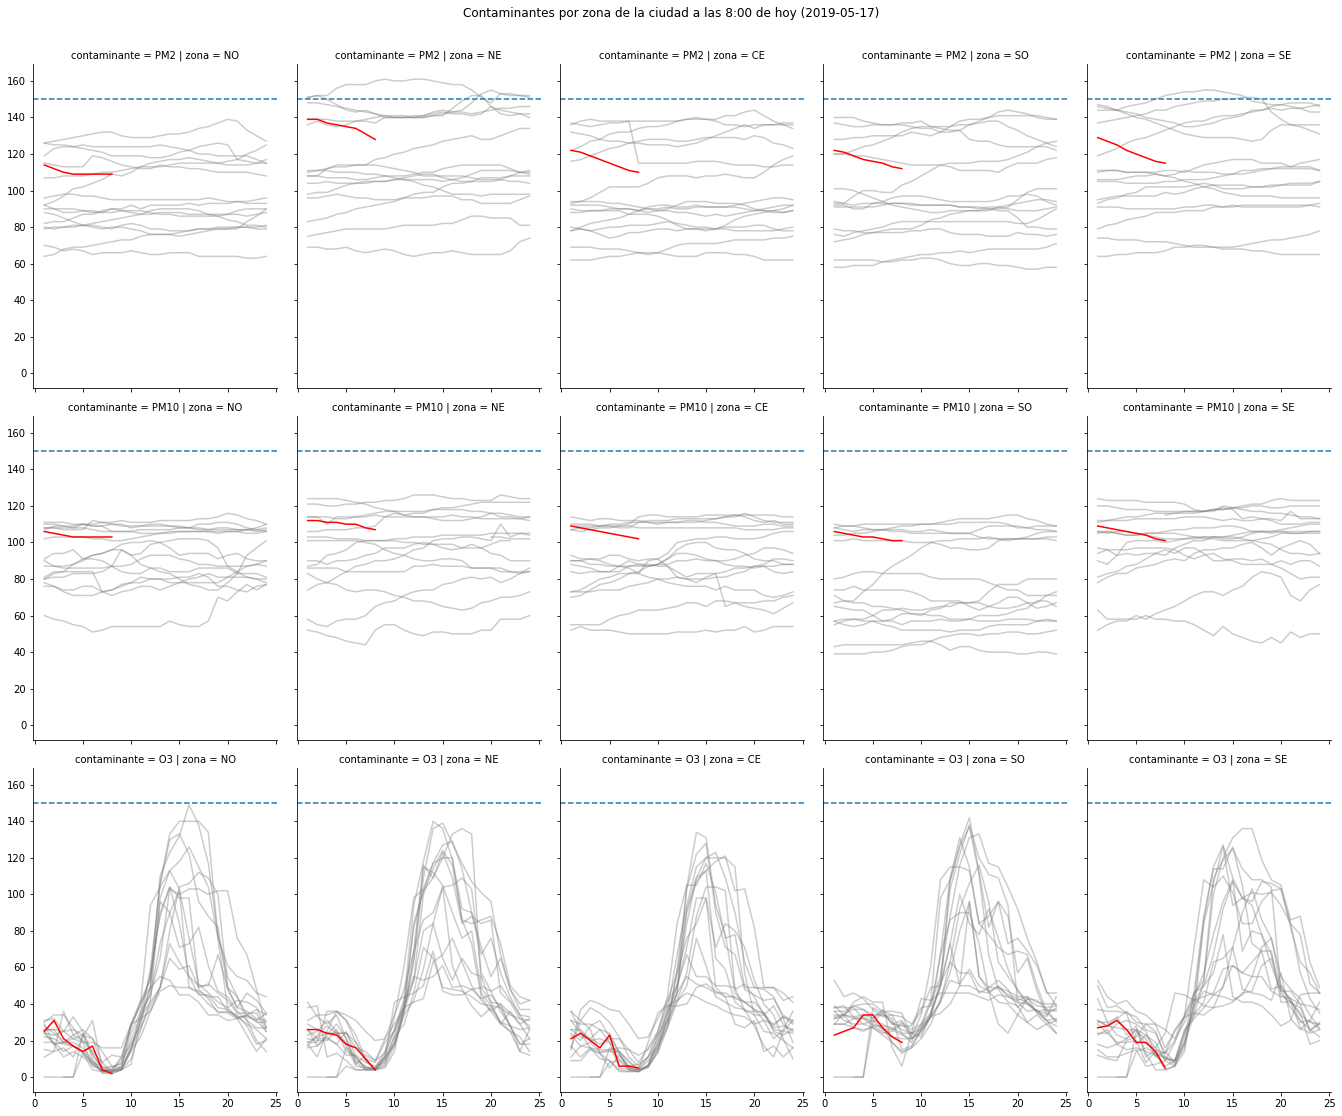

In [18]:
# Gráfica
g = sns.relplot(x="Hora", y="imecas", hue="Fecha", col="zona", row='contaminante',
            height=5, aspect=.75, facet_kws=dict(sharex=True, sharey=True), 
            kind="line", legend=False, data=df, palette=palette, row_order=row_order)
# Para reducir alpha de líneas grises
for row in g.axes:
    for f in row:
        for l in f.get_lines():
            if l.get_color()!='red':
                l.set_alpha(0.4)
# Título
g.fig.suptitle(f'Contaminantes por zona de la ciudad a las {max_hora}:00 de hoy ({hoy_iso})', y=1.03)
# Línea horizontal
g.map(sns.utils.plt.axhline, y=150, linestyle='--')
# Guarda
g.fig.savefig(f'graficas/Contaminantes {hoy_iso} a las {max_hora}.png', dpi=300, bbox_inches='tight')